In [ ]:
!unzip epics\ project\ 2024.zip

Archive:  epics project 2024.zip
   creating: epics project 2024/
   creating: epics project 2024/test/
   creating: epics project 2024/test/HBV/
  inflating: epics project 2024/test/HBV/cropped1000.png  
  inflating: epics project 2024/test/HBV/cropped1001.png  
  inflating: epics project 2024/test/HBV/cropped1002.png  
  inflating: epics project 2024/test/HBV/cropped1003.png  
  inflating: epics project 2024/test/HBV/cropped1004.png  
  inflating: epics project 2024/test/HBV/cropped1005.png  
  inflating: epics project 2024/test/HBV/cropped1006.png  
  inflating: epics project 2024/test/HBV/cropped1007.png  
  inflating: epics project 2024/test/HBV/cropped1008.png  
  inflating: epics project 2024/test/HBV/cropped1009.png  
  inflating: epics project 2024/test/HBV/cropped1010.png  
  inflating: epics project 2024/test/HBV/cropped1011.png  
  inflating: epics project 2024/test/HBV/cropped1012.png  
  inflating: epics project 2024/test/HBV/cropped1013.png  
  inflating: epics project 2

In [ ]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Dataset Preparation
data_dir = '/content/epics project 2024'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),   # Adding rotation for more variety
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adding color jitter
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Random affine transformations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")


Number of classes: 4


In [ ]:
# Model Definition (EfficientNet)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
        super(ConvBlock, self).__init__()
        self.cnnblock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups),
            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )
    def forward(self, x):
        return self.cnnblock(x)

In [ ]:
class MBBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, stride, kernel_size, padding):
        super(MBBlock, self).__init__()
        hidden_dim = in_channels * expand_ratio
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=kernel_size, stride=stride,
                      padding=padding, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.use_res_connect = stride == 1 and in_channels == out_channels

    def forward(self, x):
        if self.use_res_connect:
            return x + self.block(x)
        else:
            return self.block(x)


In [ ]:
class EfficientNet(nn.Module):
    def __init__(self, model_name, output):
        super(EfficientNet, self).__init__()
        alpha, beta = 1.2, 1.1
        scale_values = {
            "b0": (0, 224, 0.2),
            "b1": (0.5, 240, 0.2),
            "b2": (1, 260, 0.3),
            "b3": (2, 300, 0.3),
            "b4": (3, 380, 0.4),
            "b5": (4, 456, 0.4),
            "b6": (5, 528, 0.5),
            "b7": (6, 600, 0.5),
        }
        phi, resolution, dropout = scale_values[model_name]
        self.depth_factor, self.width_factor = alpha**phi, beta**phi
        self.last_channels = int(1280 * self.width_factor)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.last_channels, output)
        )
        self.feature_extractor()

    def feature_extractor(self):
        basic_mb_params = [
            [1, 16, 1, 1, 3],
            [6, 24, 2, 2, 3],
            [6, 40, 2, 2, 5],
            [6, 80, 3, 2, 3],
            [6, 112, 3, 1, 5],
            [6, 192, 4, 2, 5],
            [6, 320, 1, 1, 3],
        ]
        channels = int(32 * self.width_factor)
        features = [ConvBlock(3, channels, kernel_size=3, stride=2, padding=1)]
        in_channels = channels

        for k, c_o, repeat, s, n in basic_mb_params:
            out_channels = 4 * ((int(c_o * self.width_factor) + 3) // 4)
            num_layers = int(repeat * self.depth_factor)

            for layer in range(num_layers):
                stride = s if layer == 0 else 1
                features.append(MBBlock(in_channels, out_channels, expand_ratio=k,
                                        stride=stride, kernel_size=n, padding=n//2))
                in_channels = out_channels

        features.append(ConvBlock(in_channels, self.last_channels, kernel_size=1, stride=1, padding=0))
        self.extractor = nn.Sequential(*features)

    def forward(self, x):
        x = self.avgpool(self.extractor(x))
        return self.classifier(self.flatten(x))

In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100.0 * correct / total

In [ ]:
# Initialize Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'b0'
effnet = EfficientNet(model_name, output=num_classes).to(device)

optimizer = optim.AdamW(effnet.parameters(), lr=0.001, weight_decay=1e-4)

# Loss function
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)




# Training Function
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100.0 * correct / total

Epoch 1/50:
Train Loss: 0.5534, Train Accuracy: 79.57%
Val Loss: 0.4361, Val Accuracy: 79.33%
Model saved at /content/effb0.pth (Epoch 1)
Epoch 2/50:
Train Loss: 0.5189, Train Accuracy: 80.71%
Val Loss: 0.4218, Val Accuracy: 81.33%
Model saved at /content/effb0.pth (Epoch 2)
Epoch 3/50:
Train Loss: 0.5240, Train Accuracy: 80.71%
Val Loss: 0.4346, Val Accuracy: 79.00%
Epoch 4/50:
Train Loss: 0.5326, Train Accuracy: 78.43%
Val Loss: 0.4336, Val Accuracy: 79.33%
Epoch 5/50:
Train Loss: 0.5136, Train Accuracy: 81.29%
Val Loss: 0.4145, Val Accuracy: 80.33%
Epoch 6/50:
Train Loss: 0.4850, Train Accuracy: 82.14%
Val Loss: 0.4554, Val Accuracy: 81.33%
Epoch 7/50:
Train Loss: 0.5395, Train Accuracy: 78.57%
Val Loss: 0.4810, Val Accuracy: 77.33%
Epoch 8/50:
Train Loss: 0.5777, Train Accuracy: 75.00%
Val Loss: 0.4298, Val Accuracy: 81.00%
Epoch 9/50:
Train Loss: 0.5586, Train Accuracy: 78.00%
Val Loss: 0.4097, Val Accuracy: 81.33%
Epoch 10/50:
Train Loss: 0.5342, Train Accuracy: 79.71%
Val Loss: 

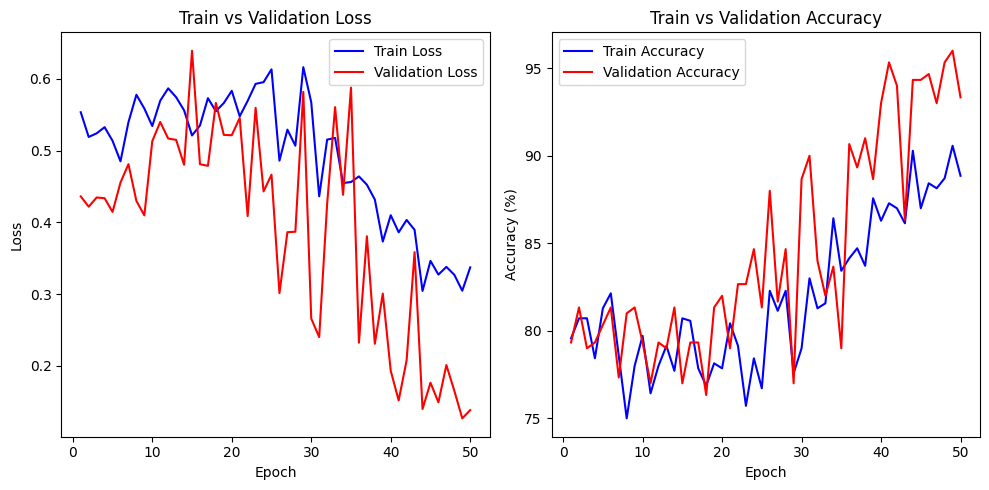

In [ ]:
import torch
import matplotlib.pyplot as plt

# Initialize lists to store the metrics for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50
best_accuracy = 0
best_model_path = "/content/effb0.pth"

# Training loop
for epoch in range(epochs):
    # Training step
    train_loss, train_accuracy = train(effnet, train_loader, optimizer, criterion, device)

    # Validation step
    val_loss, val_accuracy = evaluate(effnet, test_loader, criterion, device)

    # Scheduler step
    scheduler.step()

    # Append metrics to the lists for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print current metrics
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Save the best model based on validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(effnet.state_dict(), best_model_path)
        print(f"Model saved at {best_model_path} (Epoch {epoch+1})")

# Print the best validation accuracy
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")

# Test the model on the test set
test_loss, test_accuracy = evaluate(effnet, test_loader, criterion, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Save and download the best model
#from google.colab import files
#files.download(best_model_path)

# Plot the graphs for accuracy and loss over epochs
# Plot train and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Plot train and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Initialize Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'b1'
effnet = EfficientNet(model_name, output=num_classes).to(device)


optimizer = optim.AdamW(effnet.parameters(), lr=0.001, weight_decay=1e-4)

# Loss function
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

# Training Function
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100.0 * correct / total

Epoch 1/50:
Train Loss: 1.2665, Train Accuracy: 44.00%
Val Loss: 1.8984, Val Accuracy: 25.00%
Model saved at /content/effb1.pth (Epoch 1)
Epoch 2/50:
Train Loss: 0.9779, Train Accuracy: 58.00%
Val Loss: 3.4782, Val Accuracy: 30.67%
Model saved at /content/effb1.pth (Epoch 2)
Epoch 3/50:
Train Loss: 0.9338, Train Accuracy: 62.29%
Val Loss: 0.9532, Val Accuracy: 58.00%
Model saved at /content/effb1.pth (Epoch 3)
Epoch 4/50:
Train Loss: 0.8552, Train Accuracy: 64.29%
Val Loss: 0.8743, Val Accuracy: 66.33%
Model saved at /content/effb1.pth (Epoch 4)
Epoch 5/50:
Train Loss: 0.9256, Train Accuracy: 60.57%
Val Loss: 0.9904, Val Accuracy: 64.00%
Epoch 6/50:
Train Loss: 0.8463, Train Accuracy: 65.14%
Val Loss: 1.1135, Val Accuracy: 59.00%
Epoch 7/50:
Train Loss: 0.8847, Train Accuracy: 65.86%
Val Loss: 0.6902, Val Accuracy: 69.33%
Model saved at /content/effb1.pth (Epoch 7)
Epoch 8/50:
Train Loss: 0.7556, Train Accuracy: 68.86%
Val Loss: 0.6971, Val Accuracy: 69.00%
Epoch 9/50:
Train Loss: 0.75

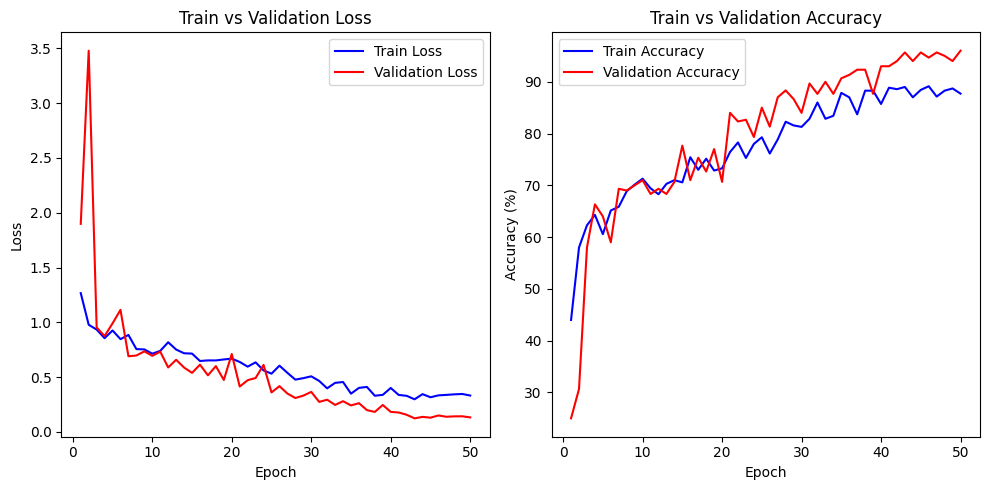

In [ ]:
import torch
import matplotlib.pyplot as plt

# Initialize lists to store the metrics for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50
best_accuracy = 0
best_model_path = "/content/effb1.pth"

# Training loop
for epoch in range(epochs):
    # Training step
    train_loss, train_accuracy = train(effnet, train_loader, optimizer, criterion, device)

    # Validation step
    val_loss, val_accuracy = evaluate(effnet, test_loader, criterion, device)

    # Scheduler step
    scheduler.step()

    # Append metrics to the lists for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print current metrics
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Save the best model based on validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(effnet.state_dict(), best_model_path)
        print(f"Model saved at {best_model_path} (Epoch {epoch+1})")

# Print the best validation accuracy
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")

# Test the model on the test set
test_loss, test_accuracy = evaluate(effnet, test_loader, criterion, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Save and download the best model
#from google.colab import files
#files.download(best_model_path)

# Plot the graphs for accuracy and loss over epochs
# Plot train and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Plot train and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Initialize Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'b4'
effnet = EfficientNet(model_name, output=num_classes).to(device)
effnet = EfficientNet(model_name, output=num_classes).to(device)


optimizer = optim.AdamW(effnet.parameters(), lr=0.001, weight_decay=1e-4)

# Loss function
criterion = nn.CrossEntropyLoss()

# Training Function
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100.0 * correct / total

Epoch 1/50:
Train Loss: 1.3577, Train Accuracy: 37.00%
Val Loss: 1.3726, Val Accuracy: 25.33%
Model saved at /content/effb4.pth (Epoch 1)
Epoch 2/50:
Train Loss: 1.0524, Train Accuracy: 52.86%
Val Loss: 2.3570, Val Accuracy: 41.00%
Model saved at /content/effb4.pth (Epoch 2)
Epoch 3/50:
Train Loss: 0.9812, Train Accuracy: 57.71%
Val Loss: 1.2726, Val Accuracy: 59.67%
Model saved at /content/effb4.pth (Epoch 3)
Epoch 4/50:
Train Loss: 0.9335, Train Accuracy: 62.14%
Val Loss: 1.1183, Val Accuracy: 64.33%
Model saved at /content/effb4.pth (Epoch 4)
Epoch 5/50:
Train Loss: 0.8460, Train Accuracy: 65.14%
Val Loss: 0.9315, Val Accuracy: 57.67%
Epoch 6/50:
Train Loss: 0.8652, Train Accuracy: 65.43%
Val Loss: 0.8448, Val Accuracy: 64.00%
Epoch 7/50:
Train Loss: 0.8300, Train Accuracy: 65.00%
Val Loss: 0.6746, Val Accuracy: 70.00%
Model saved at /content/effb4.pth (Epoch 7)
Epoch 8/50:
Train Loss: 0.8624, Train Accuracy: 64.86%
Val Loss: 0.9077, Val Accuracy: 63.67%
Epoch 9/50:
Train Loss: 0.85

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

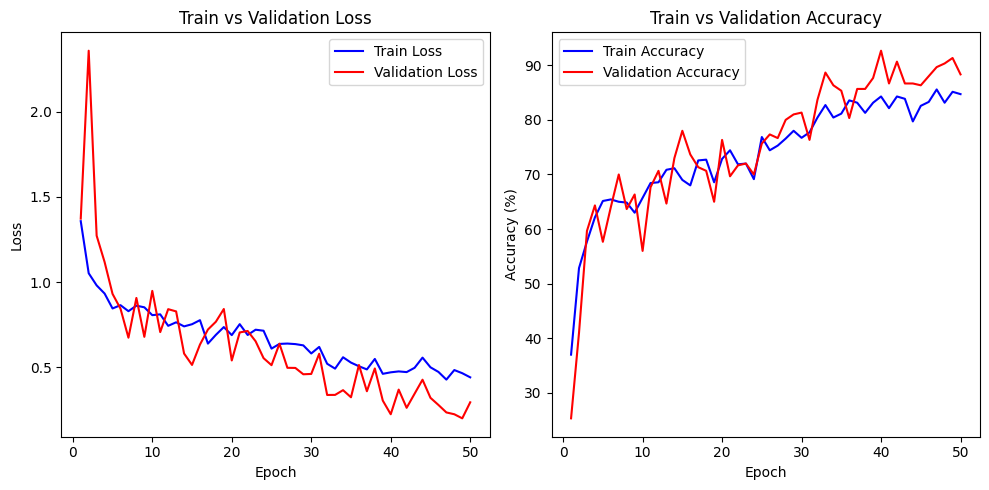

In [ ]:
import torch
import matplotlib.pyplot as plt

# Initialize lists to store the metrics for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50
best_accuracy = 0
best_model_path = "/content/effb4.pth"

# Training loop
for epoch in range(epochs):
    # Training step
    train_loss, train_accuracy = train(effnet, train_loader, optimizer, criterion, device)

    # Validation step
    val_loss, val_accuracy = evaluate(effnet, test_loader, criterion, device)

    # Scheduler step
    scheduler.step()

    # Append metrics to the lists for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print current metrics
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Save the best model based on validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(effnet.state_dict(), best_model_path)
        print(f"Model saved at {best_model_path} (Epoch {epoch+1})")

# Print the best validation accuracy
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")

# Test the model on the test set
test_loss, test_accuracy = evaluate(effnet, test_loader, criterion, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Save and download the best model
from google.colab import files
files.download(best_model_path)

# Plot the graphs for accuracy and loss over epochs
# Plot train and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Plot train and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Initialize Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'b6'
effnet = EfficientNet(model_name, output=num_classes).to(device)
effnet = EfficientNet(model_name, output=num_classes).to(device)


optimizer = optim.AdamW(effnet.parameters(), lr=0.001, weight_decay=1e-4)

# Loss function
criterion = nn.CrossEntropyLoss()

# Training Function
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100.0 * correct / total

Epoch 1/50:
Train Loss: 0.5717, Train Accuracy: 80.29%
Val Loss: 0.3200, Val Accuracy: 85.00%
Model saved at /content/effb6.pth (Epoch 1)
Epoch 2/50:
Train Loss: 0.5444, Train Accuracy: 80.00%
Val Loss: 0.5381, Val Accuracy: 87.00%
Model saved at /content/effb6.pth (Epoch 2)
Epoch 3/50:
Train Loss: 0.5056, Train Accuracy: 82.14%
Val Loss: 0.6483, Val Accuracy: 79.33%
Epoch 4/50:
Train Loss: 0.5931, Train Accuracy: 78.43%
Val Loss: 0.5239, Val Accuracy: 85.00%
Epoch 5/50:
Train Loss: 0.4753, Train Accuracy: 83.57%
Val Loss: 0.3574, Val Accuracy: 88.67%
Model saved at /content/effb6.pth (Epoch 5)
Epoch 6/50:
Train Loss: 0.4772, Train Accuracy: 81.43%
Val Loss: 0.3801, Val Accuracy: 82.00%
Epoch 7/50:
Train Loss: 0.5394, Train Accuracy: 80.00%
Val Loss: 0.2561, Val Accuracy: 89.00%
Model saved at /content/effb6.pth (Epoch 7)
Epoch 8/50:
Train Loss: 0.4241, Train Accuracy: 85.86%
Val Loss: 0.2299, Val Accuracy: 91.00%
Model saved at /content/effb6.pth (Epoch 8)
Epoch 9/50:
Train Loss: 0.49

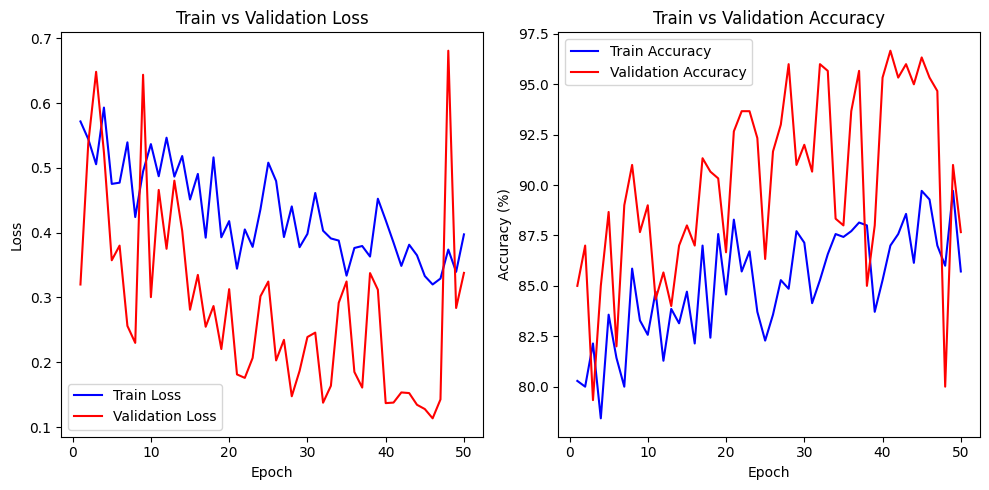

In [ ]:
import torch
import matplotlib.pyplot as plt

# Initialize lists to store the metrics for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50
best_accuracy = 0
best_model_path = "/content/effb6.pth"

# Training loop
for epoch in range(epochs):
    # Training step
    train_loss, train_accuracy = train(effnet, train_loader, optimizer, criterion, device)

    # Validation step
    val_loss, val_accuracy = evaluate(effnet, test_loader, criterion, device)

    # Scheduler step
    scheduler.step()

    # Append metrics to the lists for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print current metrics
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Save the best model based on validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(effnet.state_dict(), best_model_path)
        print(f"Model saved at {best_model_path} (Epoch {epoch+1})")

# Print the best validation accuracy
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")

# Test the model on the test set
test_loss, test_accuracy = evaluate(effnet, test_loader, criterion, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Save and download the best model
#from google.colab import files
#files.download(best_model_path)

# Plot the graphs for accuracy and loss over epochs
# Plot train and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Plot train and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn

# Define Boosting Ensemble Model
class BoostingEnsemble(nn.Module):
    def __init__(self,model0, model1,model4,model6):
        super(BoostingEnsemble, self).__init__()
        self.model0 = model0
        self.model1 = model1

        self.model4 = model4
        self.model6 = model6

    def forward(self, x):

        output0 = self.model0(x)
        output1 = self.model1(x)

        output4 = self.model4(x)
        output6 = self.model6(x)
        return (output0 + output1+output4+output6) / 4 # Averaging the predictions of b1, b2, and b3

# Load Pretrained Models
num_classes = 4
effnet_b0 = EfficientNet("b0", output=num_classes).to(device)
effnet_b1 = EfficientNet("b1", output=num_classes).to(device)

effnet_b4 = EfficientNet("b4", output=num_classes).to(device)
effnet_b6 = EfficientNet("b6", output=num_classes).to(device)

b0_path = "/content/effb0.pth"
b1_path = "/content/effb1.pth"  # Path to your saved b1 model

b4_path = "/content/effb4.pth"
b6_path = "/content/effb6.pth"

effnet_b0.load_state_dict(torch.load(b0_path, map_location=device,weights_only=True))
effnet_b1.load_state_dict(torch.load(b1_path, map_location=device,weights_only=True))

effnet_b4.load_state_dict(torch.load(b4_path, map_location=device,weights_only=True))
effnet_b6.load_state_dict(torch.load(b6_path, map_location=device,weights_only=True))

# Create Boosting Ensemble with b1, b2, and b3
boosted_model = BoostingEnsemble(effnet_b0,effnet_b1,effnet_b4,effnet_b6).to(device)

# Evaluation Function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    test_dataset = datasets.ImageFolder(root="/content/epics project 2024/test", transform=transform_train)
    dataloader = DataLoader(test_dataset, batch_size=18, shuffle=False)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = (correct_preds / total_preds) * 100

    return avg_loss, accuracy

# Save Model and Evaluation Results to File
def save_model_and_results(model, loss, accuracy, filename="all.pth"):
    # Create a dictionary to store model state and evaluation results
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'test_loss': loss,
        'test_accuracy': accuracy
    }
    torch.save(checkpoint, filename)
    print(f"Model and results saved to {filename}")

# Define your test DataLoader
test_dataset = datasets.ImageFolder(root="/content/epics project 2024/test", transform=transform_train)
test_loader = DataLoader(test_dataset, batch_size=18, shuffle=False)

# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Evaluate the model
test_loss, test_accuracy = evaluate(boosted_model, test_loader, criterion, device)

# Print results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Save the model and evaluation results
save_model_and_results(boosted_model, test_loss, test_accuracy, filename="all.pth")
#from google.colab import files
#files.download('all.pth')


Test Loss: 0.0965, Test Accuracy: 98.67%
Model and results saved to all.pth


<ipython-input-42-4b9508a6957d>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  effnet_b0.load_state_dict(torch.load(b0_path, map_location=device))
<ipython-input-42-4b950

              precision    recall  f1-score   support

     Class 0       1.00      0.96      0.98        75
     Class 1       0.99      1.00      0.99        75
     Class 2       0.96      0.99      0.97        75
     Class 3       1.00      1.00      1.00        75

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

Test Loss: 0.0965, Test Accuracy: 98.67%


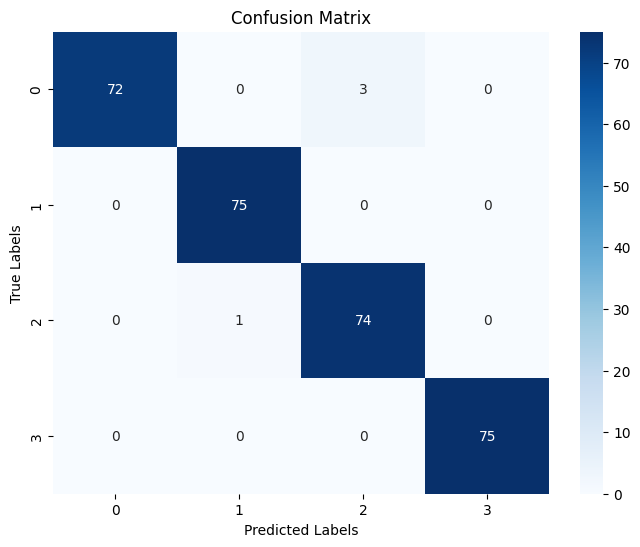

Best model saved to best_model.pth


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


# Define Boosting Ensemble Model with weighted averaging
class BoostingEnsemble(nn.Module):
    def __init__(self, model0, model1, model4, model6, weights=None):
        super(BoostingEnsemble, self).__init__()
        self.model0 = model0
        self.model1 = model1
        self.model4 = model4
        self.model6 = model6

        # If no weights provided, default to equal weights
        self.weights = weights if weights is not None else [1.0, 1.0, 1.0, 1.0]

    def forward(self, x):
        output0 = self.model0(x)
        output1 = self.model1(x)
        output4 = self.model4(x)
        output6 = self.model6(x)

        weighted_output = (
            self.weights[0] * output0 +
            self.weights[1] * output1 +
            self.weights[2] * output4 +
            self.weights[3] * output6
        )

        return weighted_output / sum(self.weights)

# Load Pretrained Models
num_classes = 4  # Adjust this as per your number of classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the models
effnet_b0 = EfficientNet("b0", output=num_classes).to(device)
effnet_b1 = EfficientNet("b1", output=num_classes).to(device)
effnet_b4 = EfficientNet("b4", output=num_classes).to(device)
effnet_b6 = EfficientNet("b6", output=num_classes).to(device)

# Load model weights
b0_path = "/content/effb0.pth"
b1_path = "/content/effb1.pth"
b4_path = "/content/effb4.pth"
b6_path = "/content/effb6.pth"

effnet_b0.load_state_dict(torch.load(b0_path, map_location=device))
effnet_b1.load_state_dict(torch.load(b1_path, map_location=device))
effnet_b4.load_state_dict(torch.load(b4_path, map_location=device))
effnet_b6.load_state_dict(torch.load(b6_path, map_location=device))

# Define weights for models (can be updated after validation results)
weights = [1.0, 1.0, 1.0, 1.0]  # Replace with actual weights based on model performance

# Create Boosting Ensemble Model
boosted_model = BoostingEnsemble(effnet_b0, effnet_b1, effnet_b4, effnet_b6, weights).to(device)

# Data Transformation and Loading
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = datasets.ImageFolder(root="/content/epics project 2024/test", transform=transform_train)
test_loader = DataLoader(test_dataset, batch_size=18, shuffle=False)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Evaluation Function with Confusion Matrix and Classification Report
def evaluate_and_report(model, dataloader, criterion, device, num_classes):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(dataloader)
    accuracy = (correct_preds / total_preds) * 100

    # Classification report
    print(classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(num_classes)]))

    return avg_loss, accuracy

# Confusion Matrix Plot
def plot_confusion_matrix(model, dataloader, device, num_classes):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Training History Plot
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.tight_layout()
    plt.show()

# Save Model with Best Performance
def save_best_model(model, filename="best_model.pth"):
    torch.save(model.state_dict(), filename)
    print(f"Best model saved to {filename}")

# Evaluate the Boosting Ensemble Model
test_loss, test_accuracy = evaluate_and_report(boosted_model, test_loader, criterion, device, num_classes)

# Print evaluation results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Plot confusion matrix
plot_confusion_matrix(boosted_model, test_loader, device, num_classes)

# Optionally, save the best model
save_best_model(boosted_model, filename="best_model.pth")
